<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/notebooks/090_Isolation_Forest_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌲 Isolation Forest: Jak szybko znaleźć odmieńca?

Większość algorytmów szuka gęstości (skupisk). Isolation Forest szuka **samotności**.

**Algorytm:**
1.  Wybierz losową cechę.
2.  Wybierz losową wartość podziału (Split) między min a max.
3.  Podziel dane na dwie grupy.
4.  Powtarzaj, aż punkt zostanie sam.

**Logika:**
*   Jeśli punkt jest **Anomalią** (leży daleko od innych), losowe cięcia bardzo szybko go oddzielą (krótka ścieżka w drzewie).
*   Jeśli punkt jest **Normalny** (w środku chmury), losowe cięcia będą długo błądzić, zanim go wyizolują (długa ścieżka).

To najszybszy algorytm do wykrywania fraudów w bankach.

Mamy 220 punktów.
Większość to 'tłum', ale 20 to 'samotne wilki'.


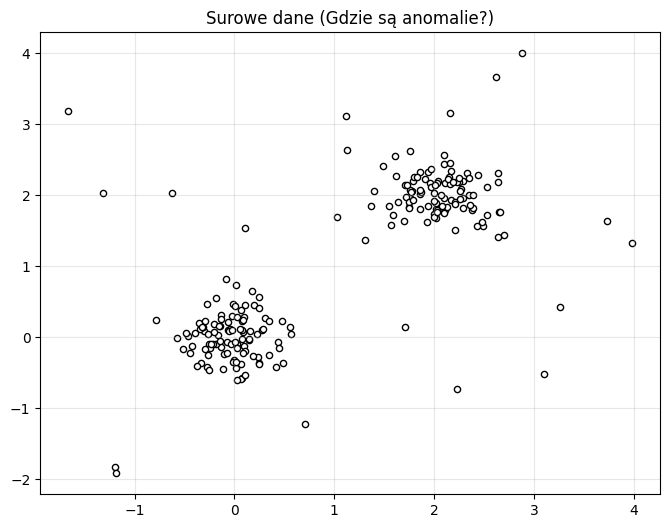

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 1. GENERUJEMY DANE
np.random.seed(42)

# Normalne transakcje (2 skupiska gęste)
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers_2 = 0.3 * np.random.randn(100, 2) + [2, 2] # Przesunięte skupisko
X_inliers = np.r_[X_inliers, X_inliers_2]

# Anomalie (Ataki - rozrzucone szeroko)
X_outliers = np.random.uniform(low=-2, high=4, size=(20, 2))

# Łączymy
X = np.r_[X_inliers, X_outliers]

print(f"Mamy {len(X)} punktów.")
print("Większość to 'tłum', ale 20 to 'samotne wilki'.")

# Wizualizacja
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], color='white', edgecolor='k', s=20)
plt.title("Surowe dane (Gdzie są anomalie?)")
plt.grid(True, alpha=0.3)
plt.show()

## Trening (Izolacja)

Używamy klasy `IsolationForest`.
Kluczowy parametr to `contamination` (zanieczyszczenie). Mówimy modelowi: *"Spodziewam się, że około 10% danych to śmieci"*.
Jeśli tego nie wiesz, ustawiasz `auto`.

In [ ]:
# Trenujemy model
# n_estimators=100 (100 losowych drzew)
# contamination=0.1 (zakładamy 10% anomalii)
clf = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
clf.fit(X)

# Predykcja
# 1 = Normalny
# -1 = Anomalia
y_pred = clf.predict(X)

# Wyniki punktowe (Anomaly Score)
# Im mniejsza liczba (bardziej ujemna), tym większa anomalia.
scores = clf.decision_function(X)

print("Przykładowe predykcje:", y_pred[:10])
print(f"Liczba wykrytych anomalii: {list(y_pred).count(-1)}")

Przykładowe predykcje: [1 1 1 1 1 1 1 1 1 1]
Liczba wykrytych anomalii: 22


## Wizualizacja Granic Decyzyjnych

Narysujemy mapę poziomic (Contour Plot).

*   **Czerwone/Żółte centrum:** "Bezpieczna strefa" (Normalność). Tutaj funkcja decyzyjna ma wysokie wartości, co oznacza duże zagęszczenie danych.
*   **Niebieskie/Granatowe tło:** "Strefa zagrożenia" (Anomalia). Tutaj funkcja decyzyjna ma niskie wartości, co oznacza, że algorytm szybko "odizolował" te punkty.

Zauważysz, że Isolation Forest nie rysuje idealnych kółek (jak Gaussian), ale poszarpane prostokąty – to efekt losowych cięć pionowych i poziomych.

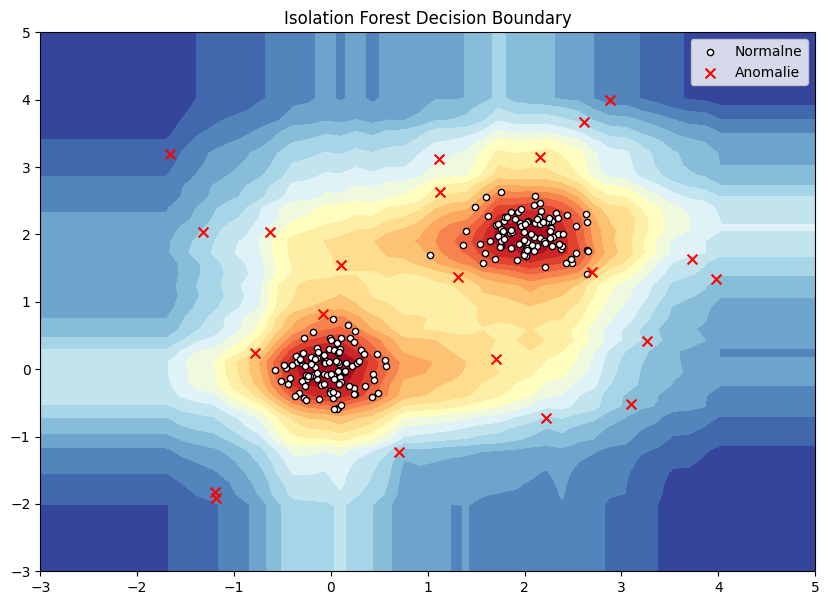

In [ ]:
# Siatka do rysowania tła
xx, yy = np.meshgrid(np.linspace(-3, 5, 50), np.linspace(-3, 5, 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 7))

# Rysujemy mapę (poziomice)
# cmap='RdYlBu_r' oznacza: Wysokie wartości (Norma) = Czerwony, Niskie (Anomalia) = Niebieski
plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), Z.max(), 20), cmap='RdYlBu_r')

# Rysujemy punkty
inliers = X[y_pred == 1]
outliers = X[y_pred == -1]

plt.scatter(inliers[:, 0], inliers[:, 1], c='white', edgecolor='k', s=20, label='Normalne')

# Poprawka: Dla markera 'x' używamy tylko parametru 'c', usuwamy 'edgecolor'
plt.scatter(outliers[:, 0], outliers[:, 1], c='red', s=50, marker='x', label='Anomalie')

plt.title("Isolation Forest Decision Boundary")
plt.legend()
plt.show()

## 🧠 Podsumowanie: Drzewa vs Autoenkodery

Kiedy użyć czego?

1.  **Isolation Forest:**
    *   **Dane tabelaryczne** (Excel, logi, finanse).
    *   Wymaga **szybkości** (działa w milisekundy).
    *   Nie wymaga GPU.
    *   *Wada:* Słabo radzi sobie z obrazami i dźwiękiem (bo tam "izolacja piksela" nie ma sensu).

2.  **Autoencoder (Deep Learning):**
    *   **Dane złożone** (Obrazy, Audio, Szeregi czasowe EKG).
    *   Gdy anomalie są subtelne (np. lekka arytmia serca, której nie widać jako "odległego punktu", ale jako "dziwny kształt").
    *   *Wada:* Wolny trening, wymaga GPU.